In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import h5py, pickle, subprocess
import umap, scipy
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [43]:
trajl = 9 # Trajectory Length for morphodynamical trajectory analysis
wellsInfo = 'Awells'
conditions = ['A2'] # LIGANDS or CONDITIONS
tmSet = ['EGF1']
n_conditions = len(tmSet) # Total number of Ligand Conditions
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = sysName+'_tlen'+str(trajl)+'_'+date2day

In [44]:
# Indices for the ligands 
inds_tmSet = [i for i in range(n_conditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 1
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(n_conditions)]
modelList = [None]*(nfovs*(n_conditions))
modelList_conditions = np.zeros(nfovs*(n_conditions)).astype(int)

In [45]:
i = 0
icond = 0
for cond in conditions:
    modelList_conditions[i] = icond
    modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fovs[0])+dateSet[imagingSet[icond]]
    print("Models: ",modelList[i])
    i = i + 1
    icond = icond + 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

Models:  /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1


In [46]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print('loaded '+objFile+' with '+str(modelSet[i].cells_indSet.size)+' cells')
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells


In [47]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [48]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [49]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)

# get cell counts
n_conds = len(tmSet)
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    inds_tmSet_models[i] = inds_tmSet[icond] # Assign indices "tmSet" to all FOVs
    inds_imagingSet_models[i] = imagingSet[icond]
    icond = icond + 1

In [50]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

In [51]:
nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [52]:
wctm = cellTraj.Trajectory() # import Trajectory object 
nfeat = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, nfeat))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        # Indices for each model for later access using them
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [53]:
varCutOff = 10
from sklearn.decomposition import PCA #we will use the sklearn package (intended for ease of use over performance/scalability)
pca = PCA(n_components = varCutOff) #n_components specifies the number of principal components to extract from the covariance matrix
pca.fit(Xf) #builds the covariance matrix and "fits" the principal components
Xpca = pca.transform(Xf) #transforms the data into the pca representation
nPCs = Xpca.shape[1]

wctm.Xpca = Xpca; wctm.pca = pca
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xpca = Xpca[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [54]:
self = wctm
wctm.trajl = trajl
all_trajSet = [None]*nmodels
for i in indgood_models:
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell 35855, 2 tracks, 31300 left
tracked cell

In [55]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory 
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length + 1):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

In [56]:
# Single-cell trajectories over the dimensionally reduced cell features
Xpcat = np.zeros((0, pca.n_components_*trajl + nfeat_com*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
cellinds0_traj = np.array([])
cellinds1_traj = np.array([])
cb_ratio_traj = np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xpca[modelSet[i].traj, :] 
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xpca.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xpcat = np.append(Xpcat, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    indframes = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame index at the start of the snippet
    indframes_traj = np.append(indframes_traj, indframes) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories
    cellinds0 = modelSet[i].traj[:, 0] # Cell indices at the start of snippets 
    cellinds0_traj = np.append(cellinds0_traj, cellinds0)
    cellinds1 = modelSet[i].traj[:, -1] # Cell indices at the end of snippets 
    cellinds1_traj = np.append(cellinds1_traj, cellinds1)
    cb_ratio_traj = np.append(cb_ratio_traj, modelSet[i].Xf[cellinds1, 77])

cellinds0_traj = cellinds0_traj.astype(int)
cellinds1_traj = cellinds1_traj.astype(int)

building trajectory data for model 0...


In [57]:
neigen_umap = 2
reducer = umap.UMAP(n_neighbors=200, min_dist=0.1, n_components=neigen_umap, metric='euclidean')
trans = reducer.fit(Xpcat)
x_umap = trans.embedding_

In [58]:
neigen = Xpcat.shape[1] # If embedded trajectories aren't UMAP'ed 
inds_conditions = [None]*n_conds
for imf in range(n_conds):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for imodel in indmodels:
        indtm = np.where(indtreatment_traj == imodel)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy() # Condition (Model) specific trajectory snippet indices: Add up all FOVs
    #print(inds_conditions[imf])

In [59]:
##### Cluster single-cell trajectories of a given snippet length by using KMeans from deeptime 
from deeptime.clustering import KMeans
n_clusters = 10
model = KMeans(n_clusters = n_clusters,  # Place 200 cluster centers
               init_strategy = 'kmeans++',  # kmeans++ initialization strategy
               max_iter = 0,  # don't actually perform the optimization, just place centers
               fixed_seed = 13)
################################ Initial clustering ###############################
clustering = model.fit(Xpcat).fetch_model() # If embedded trajectories aren't UMAP'ed 

model.initial_centers = clustering.cluster_centers
model.max_iter = 5000
clusters = model.fit(Xpcat).fetch_model() # If embedded trajectories aren't UMAP'ed 
wctm.clusterst = clusters

Map Trajectory Snippets on Microstates and Assign CC Values of The First Frames of Snippets

In [60]:
# Consider frames only in the range of 24+-6, i.e., 18-30 hours -> frame numbers: 72-120
# Note: images are collected at the interval of 15 minutes for 48 hours
fl = 72 
fu = 120 #fu = nframes
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0] # Indices 

In [61]:
# Get Cross correlations & respective frame numbers along all single-cell trajectories
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [62]:
# Get cross-correlation values along all single-cell trajectories (sorted as per trajectory length) 
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/dcompCCtraj_states/'
cc_filename = f"{cc_path}{sysName}_{conditions[0]}_1.dat"
cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

In [63]:
n_microstates = n_clusters
x_umap_by_microstates = [[[] for _ in range(n_microstates)] for _ in range(n_conditions)]
cc_values_by_microstates = [[[] for _ in range(n_microstates)] for _ in range(n_conditions)]
for cond in range(n_conds):
    indstm = inds_conditions[cond] # Condition Specific Indices
    indstwm = np.intersect1d(indstm, indstw) # Indices of trajectory snippets within frame range (72 - 120)
    x0 = Xpcat[indstwm, :] # keep trajectory snippets that are within the given frame range
    ind_map_micro = clusters.transform(x0).astype(int)
    for si in range(n_microstates):
        ind_map = np.where(ind_map_micro == si)[0]
        ind_map_Xpcat = indstwm[ind_map]
        x_umap_slice = x_umap[ind_map_Xpcat]
        x_umap_slice = np.atleast_2d(x_umap_slice)
        x_umap_by_microstates[cond][si].append(x_umap_slice)
        fid_micro_snippets = indframes_traj[ind_map_Xpcat].astype(int) # Map frame indices of snippets
        indc_map_fulltraj_snippets = indmodel_traj_snippets[ind_map_Xpcat].astype(int) # Map Indices of Full Trajectory to Snippets 
        ################## Identify the "FULL" trajectory index and locate snippets within it ##################
        for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
            possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_micro_snippets[j])  
            indc_ccvals_traj = possible_indices[0][0]
            #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
            cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
            #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
            cc_values_by_microstates[cond][si].append(cc_vals)
#print(cc_values_by_macrostate)

<Figure size 640x480 with 0 Axes>

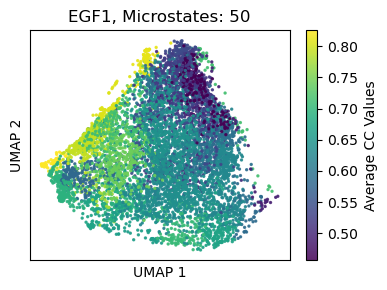

In [66]:
plt.clf()
plt.figure(figsize=(4, 3))

# Initialize a list to store the average CC values for all microstates
all_average_cc_values = []

# Collect all average CC values to determine the global min and max
for si in range(n_microstates):
    cc_values = cc_values_by_microstates[0][si]
    if len(cc_values) > 0:
        average_cc_value_per_microstate = np.mean(cc_values)
        all_average_cc_values.append(average_cc_value_per_microstate)

# Calculate the global min and max of average CC values
if all_average_cc_values:
    global_min_cc = min(all_average_cc_values)
    global_max_cc = max(all_average_cc_values)
else:
    global_min_cc = 0  # Default values in case there are no CC values at all
    global_max_cc = 1

# Plotting each microstate with the global color scale
for si in range(n_microstates):
    umap_xy = np.vstack(x_umap_by_microstates[0][si])
    cc_values = cc_values_by_microstates[0][si]
    if len(cc_values) > 0:
        average_cc_value_per_microstate = np.mean(cc_values)
        scatter_plot = plt.scatter(umap_xy[:, 0], umap_xy[:, 1], 
                                   c=[average_cc_value_per_microstate]*len(umap_xy), 
                                   cmap='viridis', vmin=global_min_cc, vmax=global_max_cc,
                                   alpha=0.85, s = 2)
plt.colorbar(scatter_plot, label='Average CC Values') # Adding a color bar with the global range
plt.title(f'{tmSet[0]}, Microstates: {n_microstates}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
#plt.savefig(f"cc_values_by_microstates_{figid}_{n_microstates}.png", dpi=500, bbox_inches='tight')
plt.show()